In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import random
sys.path.insert(0, "../")
sys.path.insert(0, "../../")

from autogluon.vision import ImagePredictor, ImageDataset
import numpy as np
import pandas as pd
import pickle
import datetime
from pathlib import Path
import umap
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from IPython.display import HTML
from matplotlib import pyplot as plt
from cleanlab.internal.label_quality_utils import get_normalized_entropy

from approximate_nearest_neighbors import ApproxNearestNeighbors

# mahalanobis
from mahalanobis import fit_mahalanobis, score_mahalanobis


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

random.seed(10)

## Read data

In [ ]:
%%time

model = "swin_base_patch4_window7_224" 

data_model_dict = {
    "cifar-10": {"data_path": "/Data/cifar10_png/"},
    "cifar-100": {"data_path": "/Data/cifar100_png/"},
    "roman-numeral": {"data_path": "/Data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/"},
    "mnist": {"data_path": "/Data/mnist_png/mnist_png/"},
    "fashion-mnist": {"data_path": "/Data/fashion_mnist_png/"}
}

# Get data, model, and pre-trained features
for dataset in data_model_dict.keys():
    
    print("--------------------------")
    print(f"Getting data for {dataset}")
    
    # Get path to data
    data_path = data_model_dict[dataset]["data_path"]
    
    # Get train and test data
    data_model_dict[dataset]["train_data"], _, data_model_dict[dataset]["test_data"] = \
        ImageDataset.from_folders(root=data_path)
    
    # Get path to saved model
    data_model_dict[dataset]["model"] = f"./autogluon_models/{model}_{dataset}.ag"

## Evaluate models on test data as a sanity check

In [ ]:
%%time

accuracy_result_list = []

for key, data in data_model_dict.items():
    
    dataset = key
    model_path = data["model"]
    test_dataset = data["test_data"]
    
    print("----------------------------------")
    print(f"Dataset: {dataset}")
    
    # load model
    print("  Loading model...")
    predictor_loaded = ImagePredictor.load(model_path)
    
    # evaluating model on test data
    print("  Evaluating model...")
    eval_ = predictor_loaded.evaluate(test_dataset)
    print(f"    Evaluation: {eval_}")
    
    accuracy_result = {
        "dataset": dataset,
        "top1": eval_["top1"]
    }
    
    accuracy_result_list.append(accuracy_result)

## Evaluate OOD Scores on TEST data

## Save the pred_probs and features used for OOD scoring

In [ ]:
%%time

# pairs of (in-distribution, out-of-distribution) datasets to evaluate
in_out_pairs = [
    {"in": "cifar-10", "out": "cifar-100"},
    {"in": "cifar-100", "out": "cifar-10"},
    {"in": "mnist", "out": "roman-numeral"},
    {"in": "roman-numeral", "out": "mnist"},
    {"in": "mnist", "out": "fashion-mnist"},
    {"in": "fashion-mnist", "out": "mnist"},
]

for in_out_pair in in_out_pairs:
    
    in_dataset, out_dataset = in_out_pair["in"], in_out_pair["out"]
    
    # path to model trained on in-distribution train dataset
    in_model_path = data_model_dict[in_dataset]["model"]

    # get in-distribution TRAIN dataset
    in_train_dataset = data_model_dict[in_dataset]["train_data"]
    in_train_dataset_class_labels = in_train_dataset.label.values # class labels for the in-distribution train dataset
    
    # get TEST datasets used for evaluation
    in_test_dataset = data_model_dict[in_dataset]["test_data"]
    in_test_dataset_class_labels = in_test_dataset.label.values # class labels for the in-distribution test dataset

    out_test_dataset = data_model_dict[out_dataset]["test_data"]
    
    print("-----------------------------------------------------")
    print("(in-distribution, out-of-distribution) dataset pair: ", in_dataset, out_dataset)
    
    # load model (trained on training set)
    print("  Loading model...")
    in_predictor_loaded = ImagePredictor.load(in_model_path)
    
    # Get predicted probabilities
    print("  Generating predicted probabilities...")
    in_train_pred_probs = in_predictor_loaded.predict_proba(data=in_train_dataset, as_pandas=False)    
    in_test_pred_probs = in_predictor_loaded.predict_proba(data=in_test_dataset, as_pandas=False)
    out_test_pred_probs = in_predictor_loaded.predict_proba(data=out_test_dataset, as_pandas=False)
    
    # Get LEARNED embeddings
    print("  Extracting learned embeddings...")
    in_train_features = \
        np.stack(
            in_predictor_loaded.predict_feature(data=in_train_dataset, as_pandas=False)[:, 0]
        )
    in_test_features = \
        np.stack(
            in_predictor_loaded.predict_feature(data=in_test_dataset, as_pandas=False)[:, 0]
        )
    out_test_features = \
        np.stack(
            in_predictor_loaded.predict_feature(data=out_test_dataset, as_pandas=False)[:, 0]
        )    
    
    # Save files here
    out_folder = f"./experiment_in_{in_dataset}_out_{out_dataset}/"
    
    # Create folder if it doesn't exist
    os.makedirs(out_folder, exist_ok=True)

#     np.save(out_folder + "in_train_pred_probs.npy", in_train_pred_probs)
#     np.save(out_folder + "in_test_pred_probs.npy", in_test_pred_probs)
#     np.save(out_folder + "out_test_pred_probs.npy", out_test_pred_probs)
    
#     np.save(out_folder + "in_train_features.npy", in_train_features)
#     np.save(out_folder + "in_test_features.npy", in_test_features)
#     np.save(out_folder + "out_test_features.npy", out_test_features)
    
#     np.save(out_folder + "in_train_dataset_class_labels.npy", in_train_dataset_class_labels)
#     np.save(out_folder + "in_test_dataset_class_labels.npy", in_test_dataset_class_labels)

## Run OOD scoring on loaded pred_probs and features

In [2]:
def cross_entropy(p, q):
    return -np.sum(p * np.log(q)) / q.shape[0]

In [3]:
%%time

# pairs of (in-distribution, out-of-distribution) datasets to evaluate
in_out_pairs = [
    {"in": "cifar-10", "out": "cifar-100"},
    {"in": "cifar-100", "out": "cifar-10"},
    {"in": "mnist", "out": "roman-numeral"},
    {"in": "roman-numeral", "out": "mnist"},
    {"in": "mnist", "out": "fashion-mnist"},
    {"in": "fashion-mnist", "out": "mnist"},
]

k_max = 110

results_list = []

for in_out_pair in in_out_pairs:
    
    in_dataset, out_dataset = in_out_pair["in"], in_out_pair["out"]
    
    print("-----------------------------------------------------")
    print("(in-distribution, out-of-distribution) dataset pair: ", in_dataset, out_dataset)
    
    # Save files here
    out_folder = f"./experiment_in_{in_dataset}_out_{out_dataset}/"
    
    # Load files
    in_train_pred_probs = np.load(out_folder + "in_train_pred_probs.npy")
    in_test_pred_probs = np.load(out_folder + "in_test_pred_probs.npy")
    out_test_pred_probs = np.load(out_folder + "out_test_pred_probs.npy")
    
    in_train_features = np.load(out_folder + "in_train_features.npy")
    in_test_features = np.load(out_folder + "in_test_features.npy", )
    out_test_features = np.load(out_folder + "out_test_features.npy")
    
    in_train_dataset_class_labels = np.load(out_folder + "in_train_dataset_class_labels.npy")
    in_test_dataset_class_labels = np.load(out_folder + "in_test_dataset_class_labels.npy")

    # Combine pred_probs and features for TEST dataset
    test_pred_probs = np.vstack([in_test_pred_probs, out_test_pred_probs])
    test_features = np.vstack([in_test_features, out_test_features]) # LEARNED embeddings
    
    # Create OOD binary labels (1 = out-of-distribution)
    in_labels = np.zeros(shape=len(in_test_pred_probs))
    out_labels = np.ones(shape=len(out_test_pred_probs))
    ood_mask = np.hstack([in_labels, out_labels]).astype(int) # OOD binary indicator

    #### Compute nearest neighbors
    
    # nearest neighbors
    nns = ApproxNearestNeighbors(
            features=in_train_features, # in-distribution TRAIN dataset features
            labels=in_train_dataset_class_labels,
            ) # init Nearest Neighbor Scorer
    nns.build_index() # build index for nearest neighbor lookup
    # _, _, _ = nns.get_k_nearest_neighbors(k=k_max)
    
    #### Get scores
    
    # Train Entropy
    in_train_entropy = get_normalized_entropy(in_train_pred_probs)
    
    # Fit Mahalanobis
    print("Fitting Mahalanobis...")
    num_class = np.unique(in_train_dataset_class_labels).shape[0]
    m = fit_mahalanobis(features=in_train_features, labels=in_train_dataset_class_labels, num_class=num_class) # fit on TRAIN in-distribution data
    
    # Fit Isolation Forest
    print("Fitting Isolation Forest...")
    if_model = IsolationForest(random_state=0, n_estimators=100) # instantiate model
    if_model.fit(in_train_features) # fit on TRAIN in-distribution data
    
    #### Define vectorized lambda functions to get nearest neighbor scores

    # neighbors here are from training datapoints
    get_train_neighbor_pred_probs = np.vectorize(lambda idx: in_train_pred_probs[idx], signature='()->(n)') # Used to get pred_probs of neighbors    
    get_train_neighbor_entropy = np.vectorize(lambda idx: in_train_entropy[idx]) # Used to get entropy of neighbors
    
    #### Get nearest neighbors for each test datapoint
    neighbors_idx = []
    neighbors_dist = []
    for v in test_features:
        # NOTE: here, the nearest neighbors are from the training dataset
        train_idx, train_dist = nns.ann_index.get_nns_by_vector(v, k_max, search_k=-1, include_distances=True)
        neighbors_idx.append(train_idx)
        neighbors_dist.append(train_dist)
    neighbors_idx = np.array(neighbors_idx)
    neighbors_dist = np.array(neighbors_dist)
    
    
    #### Get nearest neighbors for each test datapoint with features concatenated with pred_probs
    # nearest neighbors with features + pred_probs concatenated
    nns_w_pred_probs = ApproxNearestNeighbors(
        features=np.hstack([in_train_features, in_train_pred_probs]), # in-distribution TRAIN dataset features + pred_probs concatenated
        labels=in_train_dataset_class_labels,
    ) # init Nearest Neighbor Scorer
    nns_w_pred_probs.build_index() # build index for nearest neighbor lookup
    # _, _, _ = nns_w_pred_probs.get_k_nearest_neighbors(k=k_max)

    #### Get nearest neighbors for each test datapoint with pred_probs concatenated
    test_features_w_pred_probs = np.hstack([test_features, test_pred_probs])
    
    neighbors_idx_w_pred_probs = []
    neighbors_dist_w_pred_probs = []
    for v in test_features_w_pred_probs:
        # NOTE: here, the nearest neighbors are from the training dataset
        train_idx, train_dist = nns_w_pred_probs.ann_index.get_nns_by_vector(v, k_max, search_k=-1, include_distances=True)
        neighbors_idx_w_pred_probs.append(train_idx)
        neighbors_dist_w_pred_probs.append(train_dist)
    neighbors_idx_w_pred_probs = np.array(neighbors_idx_w_pred_probs)
    neighbors_dist_w_pred_probs = np.array(neighbors_dist_w_pred_probs)
    
    
    #### Get scores for test dataset
    
    # 1 - Max Pred Probs
    test_one_minus_max_pred_prob = 1. - test_pred_probs.max(axis=1)

    # Entropy
    test_entropy = get_normalized_entropy(test_pred_probs)

    #### KNN scores
    
    k = 10
    
    # KNN entropy
    knn_k10_test_entropy = (get_train_neighbor_entropy(neighbors_idx[:, :k]).sum(axis=1) + test_entropy) / (k + 1) # include the entropy of test datapoint itself in the avg

    # KNN distance
    knn_k10_test_dist = neighbors_dist[:, :k].mean(axis=1)
    
    # KNN distance where features concatenated with pred_probs
    knn_k10_test_dist_w_pred_probs = neighbors_dist_w_pred_probs[:, :k].mean(axis=1)
    
    # cross-entropy between test pred_prob and KNN avg pred_probs
    neighbor_pred_probs = get_train_neighbor_pred_probs(neighbors_idx[:, :k])
    neighbor_pred_probs_avg = neighbor_pred_probs.mean(axis=1)
    ce_knn_k10_neighbor_pred_probs_avg = -(test_pred_probs * np.log(neighbor_pred_probs_avg)).sum(axis=1) / test_pred_probs.shape[1] # -sum(p * log(q)) / num_classes    
    
    # Mahalanobis
    test_mahalanobis_score = score_mahalanobis(test_features, m)
    
    # Isolation Forest
    test_isolation_forest_score = 1 / if_model.score_samples(test_features) # take the inverse so higher scores are more anomalous    
    
    #### Evaluate scores
    
    auroc_test_one_minus_max_pred_prob = roc_auc_score(ood_mask, test_one_minus_max_pred_prob)
    auroc_test_entropy = roc_auc_score(ood_mask, test_entropy)
    auroc_knn_k10_test_entropy = roc_auc_score(ood_mask, knn_k10_test_entropy)
    auroc_knn_k10_test_dist = roc_auc_score(ood_mask, knn_k10_test_dist)
    auroc_test_mahalanobis_score = roc_auc_score(ood_mask, 1 - test_mahalanobis_score)
    auroc_test_isolation_forest_score = roc_auc_score(ood_mask, test_isolation_forest_score)
    auroc_test_ce_knn_k10_neighbor_pred_probs_avg = roc_auc_score(ood_mask, ce_knn_k10_neighbor_pred_probs_avg)
    auroc_knn_k10_test_dist_w_pred_probs = roc_auc_score(ood_mask, knn_k10_test_dist_w_pred_probs)
    
    results = {
        "in_distribution": in_dataset,
        "out_of_distribution": out_dataset,

        "auroc_test_one_minus_max_pred_prob": auroc_test_one_minus_max_pred_prob,
        "auroc_test_entropy": auroc_test_entropy,
        "auroc_knn_k10_test_entropy": auroc_knn_k10_test_entropy,
        "auroc_knn_k10_test_dist": auroc_knn_k10_test_dist,
        "auroc_knn_k10_test_dist_w_pred_probs": auroc_knn_k10_test_dist_w_pred_probs,
        
        "auroc_test_mahalanobis_score": auroc_test_mahalanobis_score,
        "auroc_test_isolation_forest_score": auroc_test_isolation_forest_score,
        "auroc_test_ce_knn_k10_neighbor_pred_probs_avg": auroc_test_ce_knn_k10_neighbor_pred_probs_avg,
    }
    
    results_list.append(results)

-----------------------------------------------------
(in-distribution, out-of-distribution) dataset pair:  cifar-10 cifar-100
Building nearest neighbors index
Fitting Mahalanobis...
Fitting Isolation Forest...
Building nearest neighbors index
-----------------------------------------------------
(in-distribution, out-of-distribution) dataset pair:  cifar-100 cifar-10
Building nearest neighbors index
Fitting Mahalanobis...
Fitting Isolation Forest...
Building nearest neighbors index
-----------------------------------------------------
(in-distribution, out-of-distribution) dataset pair:  mnist roman-numeral
Building nearest neighbors index
Fitting Mahalanobis...
Fitting Isolation Forest...
Building nearest neighbors index
-----------------------------------------------------
(in-distribution, out-of-distribution) dataset pair:  roman-numeral mnist
Building nearest neighbors index
Fitting Mahalanobis...
Fitting Isolation Forest...
Building nearest neighbors index
----------------------

## Put results to a DataFrame

In [4]:
df_results = pd.DataFrame(results_list)

In [5]:
df_results

,in_distribution,out_of_distribution,auroc_test_one_minus_max_pred_prob,auroc_test_entropy,auroc_knn_k10_test_entropy,auroc_knn_k10_test_dist,auroc_knn_k10_test_dist_w_pred_probs,auroc_test_mahalanobis_score,auroc_test_isolation_forest_score,auroc_test_ce_knn_k10_neighbor_pred_probs_avg
0,cifar-10,cifar-100,0.968904,0.968968,0.915859,0.991714,0.991614,0.989479,0.924528,0.970020
1,cifar-100,cifar-10,0.946950,0.955817,0.844693,0.957100,0.956992,0.912823,0.590674,0.954884
2,mnist,roman-numeral,0.992383,0.994569,0.949306,0.998878,0.998887,0.999668,0.991438,0.995227
3,roman-numeral,mnist,0.908997,0.929902,0.866907,0.995749,0.995751,0.995291,0.752119,0.936156
4,mnist,fashion-mnist,0.994458,0.995607,0.966390,0.999679,0.999671,0.999816,0.985299,0.996411
5,fashion-mnist,mnist,0.913697,0.937726,0.788355,0.994511,0.994358,0.998207,0.973444,0.943444


## Visualize embeddings

In [51]:
#### Choose (in_dataset, out_datset) pair to visualize

in_dataset = "cifar-100"
out_dataset = "cifar-10"

print("-----------------------------------------------------")
print("(in-distribution, out-of-distribution) dataset pair: ", in_dataset, out_dataset)

# Save files here
out_folder = f"./experiment_in_{in_dataset}_out_{out_dataset}/"

# Load files
in_train_pred_probs = np.load(out_folder + "in_train_pred_probs.npy")
in_test_pred_probs = np.load(out_folder + "in_test_pred_probs.npy")
out_test_pred_probs = np.load(out_folder + "out_test_pred_probs.npy")

in_train_features = np.load(out_folder + "in_train_features.npy")
in_test_features = np.load(out_folder + "in_test_features.npy", )
out_test_features = np.load(out_folder + "out_test_features.npy")

in_train_dataset_class_labels = np.load(out_folder + "in_train_dataset_class_labels.npy")
in_test_dataset_class_labels = np.load(out_folder + "in_test_dataset_class_labels.npy")

# Combine pred_probs and features for TEST dataset
test_pred_probs = np.vstack([in_test_pred_probs, out_test_pred_probs])
test_features = np.vstack([in_test_features, out_test_features]) # LEARNED embeddings

# Create OOD binary labels (1 = out-of-distribution)
in_labels = np.zeros(shape=len(in_test_pred_probs))
out_labels = np.ones(shape=len(out_test_pred_probs))
ood_mask = np.hstack([in_labels, out_labels]).astype(int) # OOD binary indicator

-----------------------------------------------------
(in-distribution, out-of-distribution) dataset pair:  cifar-100 cifar-10


In [52]:
%%time

reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(test_features) # project test features to 2D

CPU times: user 1min 53s, sys: 11.6 s, total: 2min 5s
Wall time: 11.4 s


In [53]:
umap_embeddings.shape

(20000, 2)

Text(0, 0.5, 'UMAP Dimension 1')

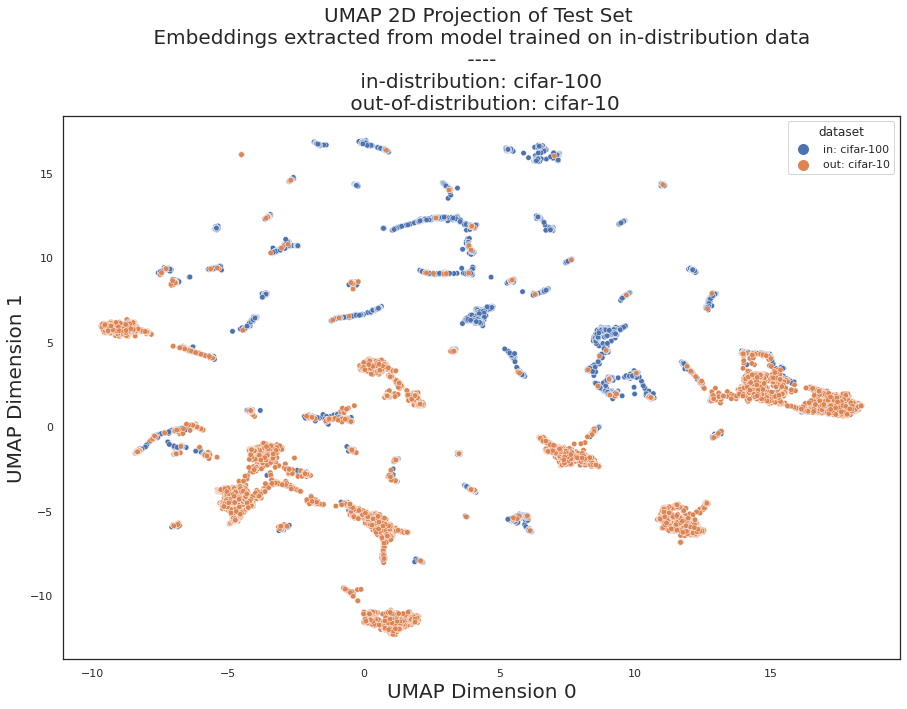

In [54]:
df_umap = pd.DataFrame({
    "e0": umap_embeddings[:, 0],
    "e1": umap_embeddings[:, 1],
    "ood_mask": ood_mask
})

df_umap["dataset"] = df_umap.ood_mask.map(lambda idx: ("in: " + in_dataset, "out: " + out_dataset)[int(idx)])

sns.set(rc = {'figure.figsize':(15,10)})
sns.set_style("white")

g = sns.scatterplot(data=df_umap, x="e0", y="e1", hue="dataset", s=30)

# Change size of marker in legend
for lh in g.legend_.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [100] 
    
g.set_title(f"UMAP 2D Projection of Test Set \n Embeddings extracted from model trained on in-distribution data \n ---- \n in-distribution: {in_dataset} \n out-of-distribution: {out_dataset}", fontsize=20)
g.set_xlabel("UMAP Dimension 0", fontsize=20)
g.set_ylabel("UMAP Dimension 1", fontsize=20)